In [1]:
# Mask-based Curve Detection Model - PyTorch Implementation
# Updated by ChatGPT - May 2025

import os
import json
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# 1. Dataset
# =========================

class MaskDataset(Dataset):
    def __init__(self, data_dir, max_lines=3):
        self.data_dir = data_dir
        self.samples = [f for f in os.listdir(data_dir) if f.endswith(".json")]
        self.max_lines = max_lines

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        json_path = os.path.join(self.data_dir, self.samples[idx])
        with open(json_path, 'r') as f:
            sample = json.load(f)

        matrix = np.array(sample['data'], dtype=np.float32)  # [128, 128]
        matrix = torch.tensor(matrix).unsqueeze(0)  # [1, 128, 128]

        masks = []
        types = []

        for m in sample['masks']:
            types.append(m['type'])
            mask_array = np.array(m['mask'], dtype=np.uint8)  # [128, 128]
            masks.append(mask_array)

        # Padding to fixed number of masks (max_lines)
        while len(masks) < self.max_lines:
            masks.append(np.zeros_like(matrix.squeeze(0)))
            types.append(-1)

        masks = np.stack(masks[:self.max_lines])  # [max_lines, 128, 128]
        types = np.array(types[:self.max_lines])  # [max_lines]

        return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)



# class MaskDataset(Dataset):
#     def __init__(self, data_dir, max_lines=3):
#         self.data_dir = data_dir
#         self.samples = [f for f in os.listdir(data_dir) if f.endswith(".json")]
#         self.max_lines = max_lines

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         json_path = os.path.join(self.data_dir, self.samples[idx])
#         with open(json_path, 'r') as f:
#             sample = json.load(f)

#         matrix = np.array(sample['data'], dtype=np.float32) / 256. # [128, 128]
#         matrix = torch.tensor(matrix).unsqueeze(0)  # [1, 128, 128]

#         masks = []
#         types = []

#         for m in sample['lines']:
#             types.append(m['type'])
#             f = np.array(m['f'], dtype=np.uint8) / 128.  # [128, 128]
#             c = np.array(m['c'], dtype=np.uint8) / 128.  # [128, 128]
            
#             masks.append([f, c])

#         # Padding to fixed number of masks (max_lines)
#         while len(masks) < self.max_lines:
#             masks.append(np.zeros_like(matrix.squeeze(0)))
#             types.append(-1)

#         masks = np.stack(masks[:self.max_lines])  # [max_lines, 128, 128]
#         types = np.array(types[:self.max_lines])  # [max_lines]

#         return matrix, torch.tensor(masks, dtype=torch.float32), torch.tensor(types, dtype=torch.long)


In [2]:
class MaskTypeTransformer(nn.Module):
    def __init__(self, in_channels=1, num_types=4, max_lines=3, embed_dim=256):
        super().__init__()
        self.max_lines = max_lines
        self.num_types = num_types

        # CNN feature extractor
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  # [B, 1, 128, 128] -> [B, 32, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 64, 64]
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 32, 32]
            nn.Conv2d(64, embed_dim, 3, padding=1),
            nn.ReLU(),        # [B, 256, 32, 32]
        )

        # Transformer encoder over flattened spatial features
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8,batch_first=True)  # ✅ 添加这个参数
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Mask head - Upsample to (512, 128)
        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),         # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, max_lines, kernel_size=2, stride=2),   # 128x128 -> 256x256
            nn.ReLU(),
            nn.Conv2d(max_lines, max_lines, kernel_size=3, padding=1),
            nn.Upsample(size=(512, 128), mode="bilinear", align_corners=False)  # 输出尺寸统一
        )

        # Type head - predict [max_lines, num_types]
        self.type_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),  # [B, C, 1, 1] -> [B, C]
            nn.Linear(embed_dim, max_lines * num_types)
        )

    def forward(self, x):
        feats = self.backbone(x)  # [B, 256, 32, 32]
        B, C, H, W = feats.shape
        flattened = feats.view(B, C, -1).permute(2, 0, 1)  # [HW, B, C]
        encoded = self.transformer(flattened).permute(1, 2, 0).view(B, C, H, W)

        masks = self.mask_head(encoded)  # [B, max_lines, 512, 128]

        types = self.type_head(encoded)  # [B, max_lines * num_types]
        types = types.view(B, self.max_lines, self.num_types)  # [B, max_lines, num_types]
        return masks, types


In [3]:
# =========================
# 3. Loss Function
# =========================

def mask_loss(pred_masks, pred_types, gt_masks, gt_types):
    bce = nn.BCEWithLogitsLoss()
    ce = nn.CrossEntropyLoss(ignore_index=-1)

    mask_loss_val = bce(pred_masks, gt_masks)

    # Reshape pred_types: [B, max_lines, num_types] -> [B*max_lines, num_types]
    # gt_types: [B, max_lines] -> [B*max_lines]
    B, N, C = pred_types.shape
    pred_types = pred_types.view(B * N, C)
    gt_types = gt_types.view(B * N)
    type_loss_val = ce(pred_types, gt_types)

    return mask_loss_val + type_loss_val


In [4]:
# =========================
# 4. Training Loop
# =========================

def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for x, y_masks, y_types in loader:
        x = x.to(device)
        y_masks = y_masks.to(device)
        y_types = y_types.to(device)

        pred_masks, pred_types = model(x)
        loss = mask_loss(pred_masks, pred_types, y_masks, y_types)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [5]:
# =========================
# 5. Visualization
# =========================

def visualize_masks(matrix, pred_masks, threshold=0.5, j=0):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
    pred_masks = torch.sigmoid(pred_masks)
    for i in range(pred_masks.shape[0]):
        mask = pred_masks[i] > threshold
        if mask.sum() > 0:
            ax.contour(mask.cpu().numpy(), levels=[0.5], colors=[f"C{i}"])
    ax.set_title("Predicted Masks")
    fig.savefig(f'save/{j:05d}.png')
    plt.show()

: 

/csim2/zhangzhiyu/miniconda3/envs/ccfj/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0: Loss = 0.1240


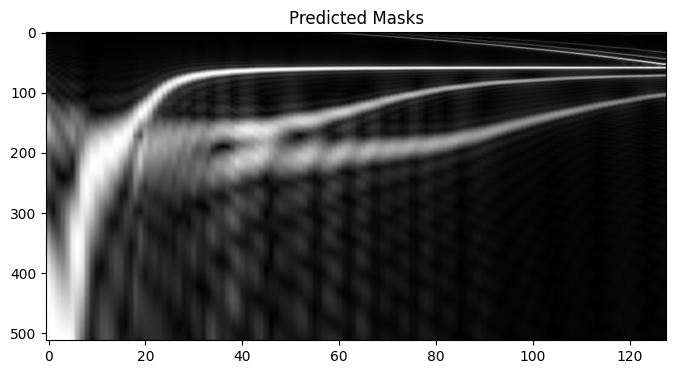

模型已保存至: checkpoints/mask_type_transformer_00000.pth
优化器状态已保存至: checkpoints/optimizer_00000.pth
Epoch 10: Loss = 0.0032
Epoch 20: Loss = 0.0020


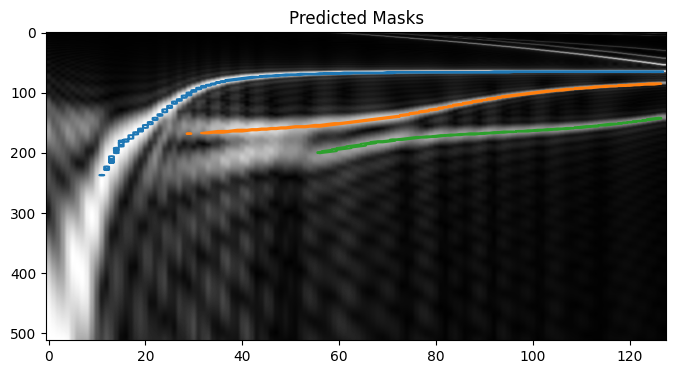

模型已保存至: checkpoints/mask_type_transformer_00020.pth
优化器状态已保存至: checkpoints/optimizer_00020.pth
Epoch 30: Loss = 0.0018
Epoch 40: Loss = 0.0014


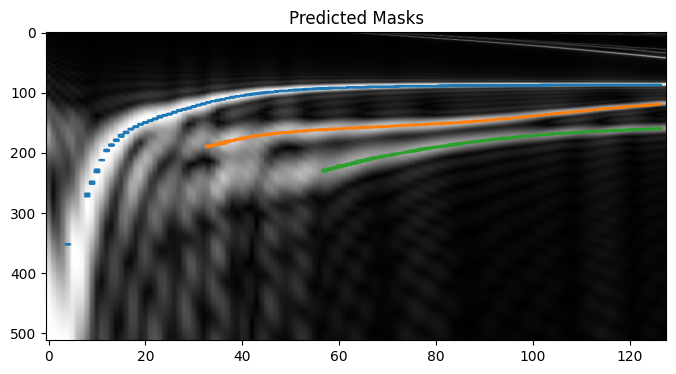

模型已保存至: checkpoints/mask_type_transformer_00040.pth
优化器状态已保存至: checkpoints/optimizer_00040.pth
Epoch 50: Loss = 0.0014
Epoch 60: Loss = 0.0012


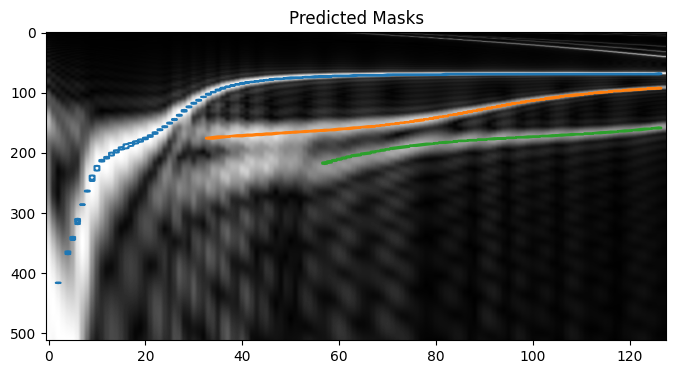

模型已保存至: checkpoints/mask_type_transformer_00060.pth
优化器状态已保存至: checkpoints/optimizer_00060.pth
Epoch 70: Loss = 0.0011
Epoch 80: Loss = 0.0011


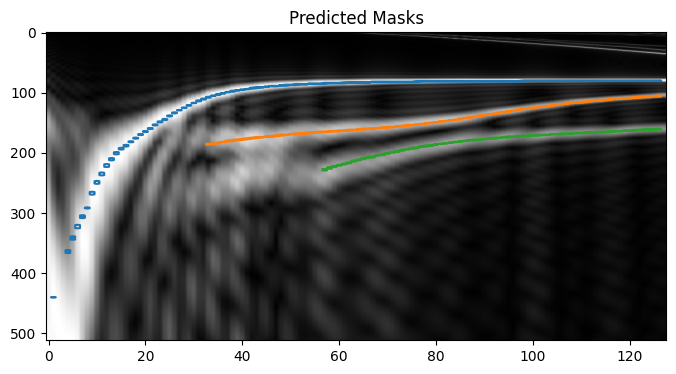

模型已保存至: checkpoints/mask_type_transformer_00080.pth
优化器状态已保存至: checkpoints/optimizer_00080.pth
Epoch 90: Loss = 0.0011
Epoch 100: Loss = 0.0010


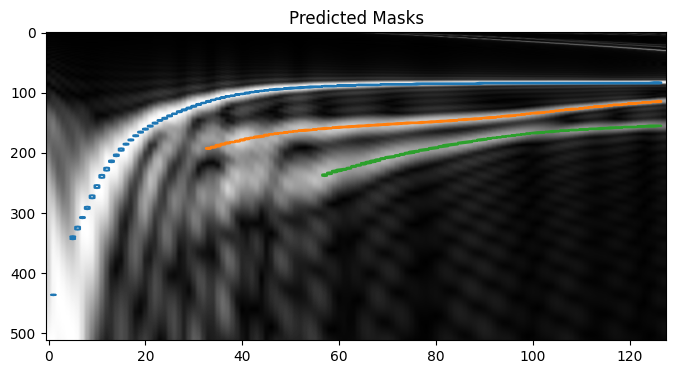

模型已保存至: checkpoints/mask_type_transformer_00100.pth
优化器状态已保存至: checkpoints/optimizer_00100.pth
Epoch 110: Loss = 0.0010
Epoch 120: Loss = 0.0010


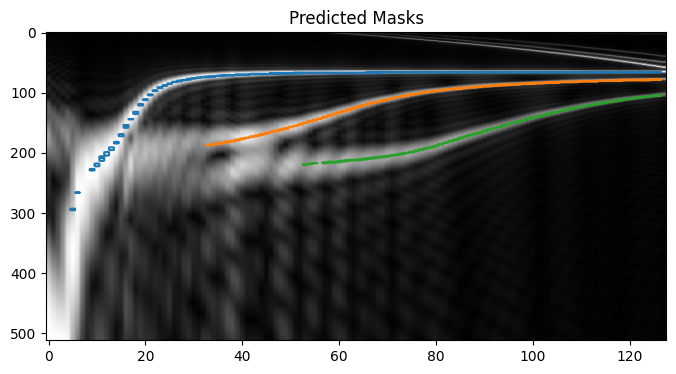

模型已保存至: checkpoints/mask_type_transformer_00120.pth
优化器状态已保存至: checkpoints/optimizer_00120.pth
Epoch 130: Loss = 0.0015
Epoch 140: Loss = 0.0013


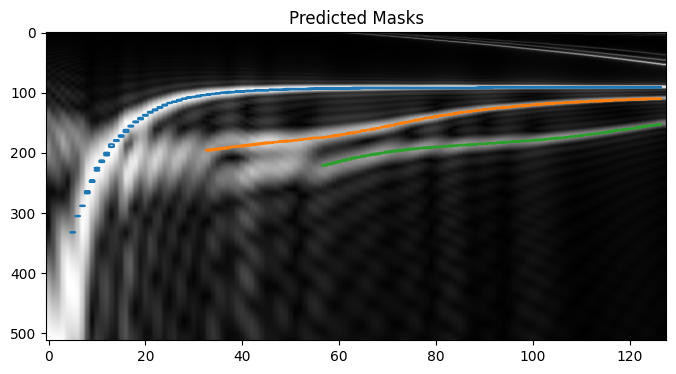

模型已保存至: checkpoints/mask_type_transformer_00140.pth
优化器状态已保存至: checkpoints/optimizer_00140.pth


In [ ]:
# =========================
# 6. Run Example
# =========================
import os


data_dir = "datasets_json"
dataset = MaskDataset(data_dir)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = MaskTypeTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history_loss = []
for epoch in range(1000):
    loss = train(model, loader, optimizer, device="cuda")
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")
        history_loss.append([epoch, loss])

    if epoch % 20 == 0:
        # 可视化最后一个 batch 的第一个样本
        x, y_masks, y_types = next(iter(loader))

        i = 1
        model.eval()
        with torch.no_grad():
            pred_masks, pred_types = model(x.cuda())
        visualize_masks(x[i], pred_masks[i], 0.1, epoch)
        
        # 保存模型权重和优化器状态，便于后续加载和复现实验
        save_dir = "checkpoints"
        os.makedirs(save_dir, exist_ok=True)
        model_path = os.path.join(save_dir, f"mask_type_transformer_{epoch:05d}.pth")
        optimizer_path = os.path.join(save_dir, f"optimizer_{epoch:05d}.pth")

        torch.save(model.state_dict(), model_path)
        torch.save(optimizer.state_dict(), optimizer_path)
        print(f"模型已保存至: {model_path}")
        print(f"优化器状态已保存至: {optimizer_path}")

history_loss = np.array(history_loss)

In [ ]:
model = MaskTypeTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.load_state_dict(torch.load(model_path, weights_only=True))
optimizer.load_state_dict(torch.load(optimizer_path, weights_only=True))


In [21]:
plt.plot(history_loss[:, 0], history_loss[:, 1])
plt.yscale('log')
plt.show()


TypeError: list indices must be integers or slices, not tuple

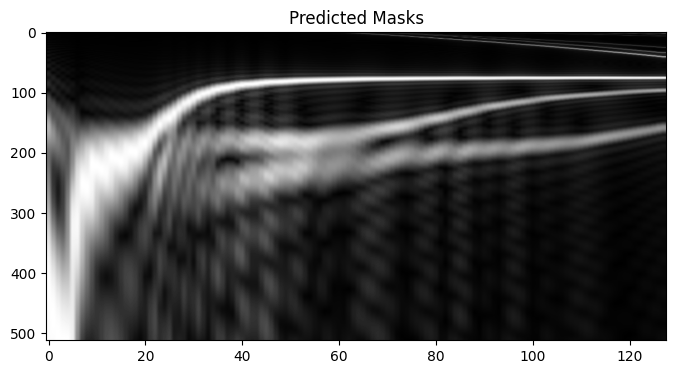

In [8]:
# 可视化最后一个 batch 的第一个样本
x, y_masks, y_types = next(iter(loader))

i = 1
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())
visualize_masks(x[i], pred_masks[i], 0.1, epoch)

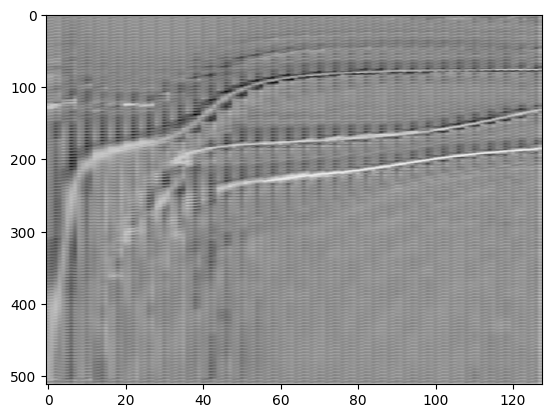

In [ ]:
j = 2
plt.imshow(pred_masks[i][j].squeeze().cpu(), cmap='gray', aspect='auto')

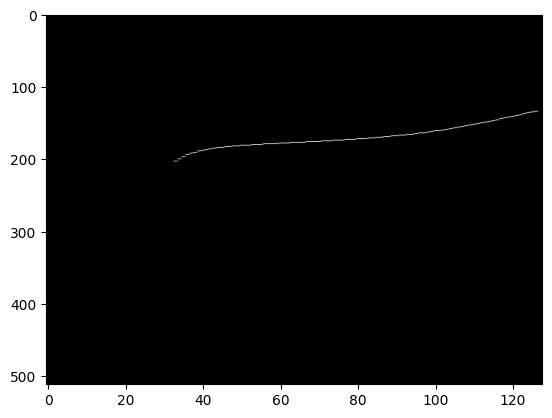

In [ ]:
j = 1
plt.imshow(y_masks[i][j].squeeze().cpu(), cmap='gray', aspect='auto')

In [12]:
x.shape, y_masks.shape, pred_masks.shape

(torch.Size([16, 1, 512, 128]),
 torch.Size([16, 3, 512, 128]),
 torch.Size([16, 3, 512, 128]))

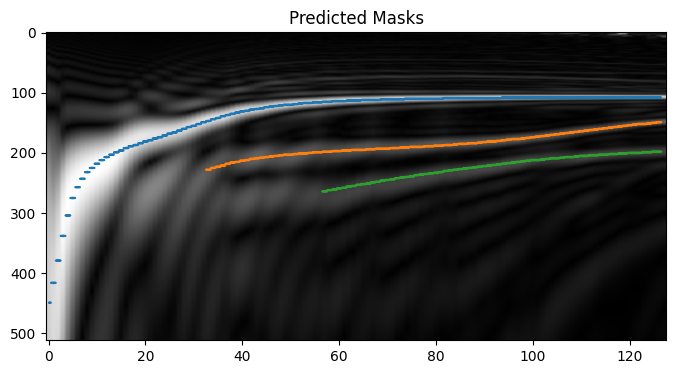

In [ ]:
i = 5
visualize_masks(x[i], y_masks[i])

In [11]:
# 可视化最后一个 batch 的第一个样本
x, y_masks, y_types = next(iter(loader))

i = 10
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())
# visualize_masks(x[i], pred_masks[i])
